In [1]:
%pip install hydra-core ray
%pip install tensorflow
%pip install matplotlib
%pip install torch torchvision torchaudio
%pip install -U ipywidgets

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [2]:
%pip install -U flwr
%pip install -q flwr[simulation] flwr-datasets[vision]

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [4]:
from collections import OrderedDict

import flwr as fl
from flwr.client import Client, ClientApp, NumPyClient
from flwr.common import Metrics, Context, Scalar, NDArrays
from flwr.server import ServerApp, ServerConfig, ServerAppComponents
from flwr.server.strategy import FedAvg
from flwr.simulation import run_simulation
from flwr_datasets import FederatedDataset

import hydra
from hydra import compose, initialize

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import random_split, DataLoader
from torchvision.transforms import ToTensor, Normalize, Compose
from torchvision.datasets import MNIST
from typing import Dict

import ray


2025-08-06 17:10:58.788207: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1754496658.972033   36839 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1754496659.024850   36839 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1754496659.442246   36839 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1754496659.442322   36839 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1754496659.442328   36839 computation_placer.cc:177] computation placer alr

In [2]:
from collections import OrderedDict
from typing import List, Tuple
from hydra import compose, initialize

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from datasets.utils.logging import disable_progress_bar
from torch.utils.data import DataLoader

import flwr
from flwr.client import Client, ClientApp, NumPyClient
from flwr.common import Metrics, Context
from flwr.server import ServerApp, ServerConfig, ServerAppComponents
from flwr.server.strategy import FedAvg
from flwr.simulation import run_simulation
from flwr_datasets import FederatedDataset

from omegaconf import DictConfig, OmegaConf
import os; 
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '1'

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Training on {DEVICE}")
# disable_progress_bar()


ROOT_DIR = "./" # relative to this file
# context initialization
with initialize(version_base=None, config_path=ROOT_DIR+"configs"):
    cfg = compose(config_name="base")

Training on cpu


In [3]:
list(cfg.keys())
print(OmegaConf.to_yaml(cfg.config))

num_rounds: 3
num_clients: 10
num_clients_per_round_fit: 5
num_clients_per_round_eval: 5
num_class: 10
num_feature: 784
batch_size: 32
learning_rate: 0.01
momentum: 0.9
weight_decay: 0.0001
local_epochs: 1
local_batch_size: 32
local_lr: 0.01
local_momentum: 0.9
local_weight_decay: 0.0001
global_epoch: 1
global_batch_size: 32
global_lr: 0.01
global_momentum: 0.9
global_weight_decay: 0.0001



## **1. Prepare the dataset**

### **Load the dataset**

In [4]:
def get_mnist(data_path: str='./datasets/'):
  # fds = FederatedDataset(dataset="cifar10", partitioners={"train": NUM_CLIENTS})
  transformations= Compose((ToTensor(), Normalize((0.1307,), (0.3081,)))) # Normalize takes as parameters the mean and the std

  trainset = MNIST(data_path, train=True, download=True, transform=transformations)
  testset = MNIST(data_path, train=False, download=True, transform=transformations)

  return trainset, testset

### **Prepare the dataset -- OLD**

In [ ]:
def prepare_dataset_old(num_clients:int,
                    batch_size: int,
                    validation_ratio: float = 0.1):

  trainset, testset = get_mnist()

  # split trainset into 'num_clients' trainsets
  num_images = len(trainset) //  num_clients

  partition_len = [num_images] * num_clients
  trainsets = random_split(trainset, partition_len, torch.Generator().manual_seed(2025)) # data distribution (IID for this code)

  # create dataloaders with train/validation support
  trainloaders, validationloaders = [], []
  for trainset in trainsets:
    num_total = len(trainset)
    num_validation = int(validation_ratio * num_total)
    num_train = num_total - num_validation

    for_train, for_validation = random_split(trainset, [num_train, num_validation], torch.Generator().manual_seed(2025))
    trainloaders.append(DataLoader(for_train, batch_size=batch_size, shuffle=True, num_workers=2))
    validationloaders.append(DataLoader(for_validation, batch_size=batch_size, shuffle=False, num_workers=2))

  testloaders = DataLoader(testset, batch_size=128, shuffle=False, num_workers=2)

  return trainloaders, validationloaders, testloaders


### **Prepare the dataset -- NEW**

In [5]:
def prepare_dataset(partition_id: int):
    fds = FederatedDataset(dataset="cifar10", partitioners={"train": cfg.config.num_clients})
    partition = fds.load_partition(partition_id)
    # Divide data on each node: 80% train, 20% test
    partition_train_test = partition.train_test_split(test_size=0.2, seed=42)
    pytorch_transforms = transforms.Compose(
        [transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
    )

    def apply_transforms(batch):
        batch["img"] = [pytorch_transforms(img) for img in batch["img"]]
        return batch

    # Create train/val for each partition and wrap it into DataLoader
    partition_train_test = partition_train_test.with_transform(apply_transforms)
    trainloader = DataLoader(
        partition_train_test["train"], batch_size=cfg.config.batch_size, shuffle=True
    )
    valloader = DataLoader(partition_train_test["test"], batch_size=cfg.config.batch_size)
    testset = fds.load_split("test").with_transform(apply_transforms)
    testloader = DataLoader(testset, batch_size=cfg.config.batch_size)
    return trainloader, valloader, testloader

Using the latest cached version of the dataset since cifar10 couldn't be found on the Hugging Face Hub
Found the latest cached dataset configuration 'plain_text' at /home/MacNight_nj/.cache/huggingface/datasets/cifar10/plain_text/0.0.0/0b2714987fa478483af9968de7c934580d0bb9a2 (last modified on Wed May  7 14:58:14 2025).
/home/MacNight_nj/.local/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead.
  obj.co_lnotab,  # for < python 3.10 [not counted in args]


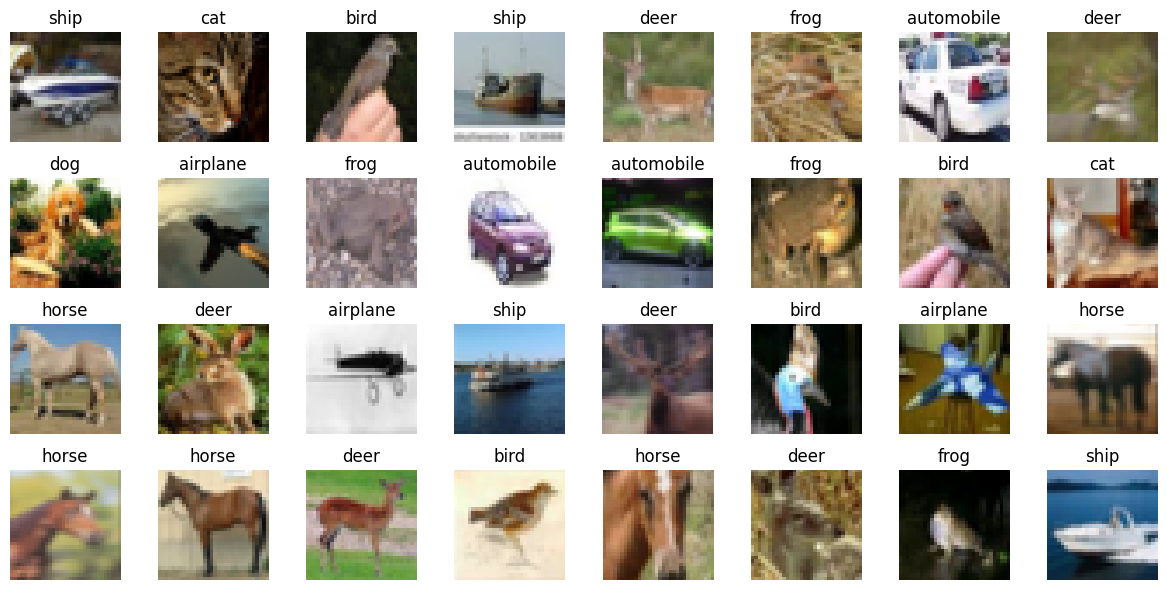

In [6]:
trainloader, validationloader, testloader = prepare_dataset(partition_id=0)
batch = next(iter(trainloader))
images, labels = batch["img"], batch["label"]

# Reshape and convert images to a NumPy array
# matplotlib requires images with the shape (height, width, 3)
images = images.permute(0, 2, 3, 1).numpy()

# Denormalize
images = images / 2 + 0.5

# Create a figure and a grid of subplots
fig, axs = plt.subplots(4, 8, figsize=(12, 6))

# Loop over the images and plot them
for i, ax in enumerate(axs.flat):
    ax.imshow(images[i])
    ax.set_title(trainloader.dataset.features["label"].int2str([labels[i]])[0])
    ax.axis("off")

# Show the plot
fig.tight_layout()
plt.show()

## **2. Define Clients -- OLD**

### **Model -- OLD**

In [ ]:
class Net_old(nn.Module):
    def __init__(self, num_classes) -> None:
        super(Net_old, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, num_classes)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

def train_old(net, trainloader, optimizer, epochs: int, device: str, verbose=False):
    """Train the network on the training set."""
    criterion = torch.nn.CrossEntropyLoss()
    net.train()
    net.to(device)
    for epoch in range(epochs):
        correct, total, epoch_loss = 0, 0, 0.0
        for images, labels in trainloader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = net(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            # Metrics
            epoch_loss += loss
            total += labels.size(0)
            correct += (torch.max(outputs.data, 1)[1] == labels).sum().item()
        epoch_loss /= len(trainloader.dataset)
        epoch_acc = correct / total
        if verbose:
            print(f"Epoch {epoch+1}: train loss {epoch_loss}, accuracy {epoch_acc}")


def test_old(net, testloader, device: str):
    """Evaluate the network on the entire test set."""
    criterion = torch.nn.CrossEntropyLoss()
    correct, total, loss = 0, 0, 0.0
    net.eval()
    net.to(device)
    with torch.no_grad():
        for batch in testloader:
            images, labels = batch[0].to(device), batch[1].to(device)
            outputs = net(images)
            loss += criterion(outputs, labels).item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    loss /= len(testloader.dataset)
    accuracy = correct / total
    return loss, accuracy

In [ ]:
class ClientOld(fl.client.NumPyClient):
  def __init__(self,
               client_id: int,
               trainloader,
               validationloader,
               num_classes) -> None:
    super().__init__()
    self.client_id = client_id
    self.trainloader = trainloader
    self.validationloader = validationloader

    self.model = Net(num_classes)
    self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

  def get_parameters(self, config: Dict[str, Scalar]):
    return [val.cpu().numpy() for key, val in self.model.state_dict().items()]

  def set_parameters(self, parameters):
    params_dict = zip(self.model.state_dict().keys(), parameters)
    state_dict = OrderedDict({key: torch.Tensor(val) for key, val in params_dict})
    self.model.load_state_dict(state_dict, strict=True)

    return

  # Fit weight parameter (wt) send by the server to the client model i.e. overriding client local model weight
  def fit(self, parameters, config):
    # Copy the parameters sent by the server into client's local model
    self.set_parameters(parameters)

    learning_rate = config['learning_rate']
    momentum = config['momentum']
    epochs = config['local_epochs']

    # define optimizer
    optimizer = torch.optim.SGD(self.model.parameters(), lr=learning_rate, momentum=momentum)

    # do local training
    train(self.model, self.trainloader, optimizer, epochs, self.device)

    return self.get_parameters(config={}), len(self.trainloader), {}

  def evaluate(self, parameters: NDArrays, config: Dict[str, Scalar]):
    self.set_parameters(parameters)
    loss, accuracy = test(self.model, self.validationloader, self.device)
    return float(loss), len(self.validationset), {"accuracy": float(accuracy)}

def generate_client(trainloaders, validationloaders, num_classes):
  def client_fn(cid: str): # cid =  client id
    return Client(client_id=int(cid),
                  trainloader=trainloaders[int(cid)],
                  validationloader=validationloaders[int(cid)],
                  num_classes=num_classes,
                  )

  return client_fn

## **2. Define Client -- NEW**

### **Model -- NEW**

In [7]:
class Net(nn.Module):
    def __init__(self) -> None:
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    
def train(net, trainloader, epochs: int, verbose=False):
    """Train the network on the training set."""
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(net.parameters())
    net.train()
    for epoch in range(epochs):
        correct, total, epoch_loss = 0, 0, 0.0
        for batch in trainloader:
            images, labels = batch["img"].to(DEVICE), batch["label"].to(DEVICE)
            optimizer.zero_grad()
            outputs = net(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            # Metrics
            epoch_loss += loss
            total += labels.size(0)
            correct += (torch.max(outputs.data, 1)[1] == labels).sum().item()
        epoch_loss /= len(trainloader.dataset)
        epoch_acc = correct / total
        if verbose:
            print(f"Epoch {epoch+1}: train loss {epoch_loss}, accuracy {epoch_acc}")


def test(net, testloader):
    """Evaluate the network on the entire test set."""
    criterion = torch.nn.CrossEntropyLoss()
    correct, total, loss = 0, 0, 0.0
    net.eval()
    with torch.no_grad():
        for batch in testloader:
            images, labels = batch["img"].to(DEVICE), batch["label"].to(DEVICE)
            outputs = net(images)
            loss += criterion(outputs, labels).item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    loss /= len(testloader.dataset)
    accuracy = correct / total
    return loss, accuracy

In [8]:
# Model training

trainloader, valloader, testloader = prepare_dataset(partition_id=0)
net = Net().to(DEVICE)

for epoch in range(cfg.config.local_epochs):
    train(net, trainloader, 1)
    loss, accuracy = test(net, valloader)
    print(f"Epoch {epoch+1}: validation loss {loss}, accuracy {accuracy}")

loss, accuracy = test(net, testloader)
print(f"Final test set performance:\n\tloss {loss}\n\taccuracy {accuracy}")

Using the latest cached version of the dataset since cifar10 couldn't be found on the Hugging Face Hub
Found the latest cached dataset configuration 'plain_text' at /home/MacNight_nj/.cache/huggingface/datasets/cifar10/plain_text/0.0.0/0b2714987fa478483af9968de7c934580d0bb9a2 (last modified on Wed May  7 14:58:14 2025).


Epoch 1: validation loss 0.05914095485210419, accuracy 0.33
Final test set performance:
	loss 0.058777632665634155
	accuracy 0.3071


### **Client App**

In [9]:
class Client(NumPyClient):
    def __init__(self, net, trainloader, valloader):
        self.net = net
        self.trainloader = trainloader
        self.valloader = valloader

    def get_parameters(self, config):
        return [val.cpu().numpy() for _, val in self.net.state_dict().items()]

    def fit(self, parameters: List[np.ndarray], config):
        params_dict = zip(self.net.state_dict().keys(), parameters)
        state_dict = OrderedDict({k: torch.Tensor(v) for k, v in params_dict})
        self.net.load_state_dict(state_dict, strict=True)
        train(self.net, self.trainloader, epochs=1)
        return [val.cpu().numpy() for _, val in self.net.state_dict().items()], len(self.trainloader), {}

    def evaluate(self, parameters: List[np.ndarray], config):
        params_dict = zip(self.net.state_dict().keys(), parameters)
        state_dict = OrderedDict({k: torch.Tensor(v) for k, v in params_dict})
        self.net.load_state_dict(state_dict, strict=True)
        loss, accuracy = test(self.net, self.valloader)
        return float(loss), len(self.valloader), {"accuracy": float(accuracy)}
    
def client_fn(context: Context) -> Client:
    """Create a client representing a single organization."""

    # Load model
    net = Net().to(DEVICE)

    # Load data (CIFAR-10)
    # Note: each client gets a different trainloader/valloader, so each client
    # will train and evaluate on their own unique data partition
    # Read the node_config to fetch data partition associated to this node
    partition_id = context.node_config["partition-id"]
    trainloader, valloader, _ = prepare_dataset(partition_id=partition_id)

    return Client(net, trainloader, valloader).to_client()


## **3. Server --  OLD**

In [10]:
def get_on_fit_config(context: Context):
    
    def fit_config_fn(server_round: int):
        return {'lr': cfg.config.learning_rate,
                'momentum': cfg.config.momentum,
                'local_epochs': cfg.config.local_epochs,
                }

    return fit_config_fn

def get_evaluate_fn(num_classes: int, testloaders):
    def evaluate_fn(server_round: int, parameters, config):
        model = Net(num_classes)
        device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        params_dict = zip(model.state_dict().keys(), parameters)
        state_dict = OrderedDict({key: torch.Tensor(val) for key, val in params_dict})
        model.load_state_dict(state_dict, strict=True)

        loss, accuracy = test(model, testloaders, device)
        return loss, {'accuracy': accuracy}

    return evaluate_fn

## **3. Model --NEW**

In [11]:
def weighted_average(metrics: List[Tuple[int, Metrics]]) -> Metrics:
    # Multiply accuracy of each client by number of examples used
    accuracies = [num_examples * m["accuracy"] for num_examples, m in metrics]
    examples = [num_examples for num_examples, _ in metrics]

    # Aggregate and return custom metric (weighted average)
    return {"accuracy": sum(accuracies) / sum(examples)}

def server_fn(context: Context) -> ServerAppComponents:
    """Construct components that set the ServerApp behaviour.

    You can use the settings in `context.run_config` to parameterize the
    construction of all elements (e.g the strategy or the number of rounds)
    wrapped in the returned ServerAppComponents object.
    """
    # Define strategy -| Federated Averaging |-
    strategy = FedAvg(
        fraction_fit=1.0,  # Sample 100% of available clients for training
        fraction_evaluate=0.5,  # Sample 50% of available clients for evaluation
        min_fit_clients=cfg.config.num_clients_per_round_fit,
        min_evaluate_clients=cfg.config.num_clients_per_round_eval,
        min_available_clients=cfg.config.num_clients,
        evaluate_metrics_aggregation_fn=weighted_average,
        # on_fit_config_fn=get_on_fit_config,
    )
    # Configure the server rounds for training
    config = ServerConfig(num_rounds=cfg.config.num_rounds)

    return ServerAppComponents(strategy=strategy, config=config)


## **4. Running Federated Learning Model**

In [12]:
def main():
  # Prepare the dataset
  # trainloaders, validationloaders, testloaders = prepare_dataset(cfg.config.num_clients,
  #                                                                cfg.config.batch_size)
  # print(f"Number of trainloaders: {len(trainloaders[0].dataset)}")
  # print(f"Number of validationloaders: {len(validationloaders[0].dataset)}")
  # print(f"Number of testloaders: {len(testloaders)}")

  # Define Clients
  client = ClientApp(client_fn=client_fn) # NEW
  # client_fn = generate_client(trainloaders, validationloaders, cfg.config.num_class) # OLD

  # Create the ServerApp
  server = ServerApp(server_fn=server_fn)

  # strategy = fl.server.strategy.FedAvg(fraction_fit=0.0001,
  #                               min_fit_clients=cfg.config.num_clients_per_round_fit,
  #                               fraction_evaluate=0.00001,
  #                               min_evaluate_clients=cfg.config.num_clients_per_round_eval,
  #                               min_available_clients=cfg.config.num_clients,
  #                               on_fit_config_fn=get_on_fit_config(cfg.config),
  #                               evaluate_fn=get_evaluate_fn(cfg.config.num_class, testloaders),
  #                               ) 
  
  # # Start simulation
  # history = fl.simulation.start_simulation(
  #   client_fn=client,
  #   num_clients=cfg.config.num_clients,
  #   config=fl.server.ServerConfig(num_rounds=cfg.config.num_rounds),
  #   strategy=strategy,
  # )

  # Run simulation
  run_simulation(
    server_app=server,
    client_app=client,
    num_supernodes=cfg.config.num_clients,
    # backend_config=backend_config,
  )

if __name__ == "__main__":
  main()


INFO :      Starting Flower ServerApp, config: num_rounds=3, no round_timeout
INFO :      
INFO :      [INIT]
INFO :      Requesting initial parameters from one random client
(pid=60074) 2025-05-11 17:32:25.168379: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
(pid=60074) WARNING: All log messages before absl::InitializeLog() is called are written to STDERR
(pid=60074) E0000 00:00:1746981145.209506   60074 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
(pid=60074) E0000 00:00:1746981145.222223   60074 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
(pid=60074) W0000 00:00:1746981145.253550   60074 computation_placer.cc:177] computation placer already registered. Please chec